In [29]:
#Import library pandas untuk membaca dataset
import pandas as pd

butterworth = pd.read_csv('Feature_Butterworth.csv')  #Untuk denoising butterworth

butterworth.columns =['ESH', 'MAD', 'SKEW','KURT','VLF','LF','HF','Label']
butterworth_feat = butterworth.drop('Label',1)
butterworth_feat['VLF'] = butterworth_feat['VLF'].fillna(butterworth_feat['VLF'].mean())
butterworth_label = butterworth['Label']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  del sys.path[0]


In [30]:
butterworth.head()

,ESH,MAD,SKEW,KURT,VLF,LF,HF,Label
0,12.667555,0.079907,0.261786,-0.725236,0.000525,0.000101,1.304105e-06,0
1,12.674413,0.076343,0.639750,0.085107,0.000281,0.000003,4.215095e-08,0
2,12.668663,0.096521,0.001104,0.438030,0.001745,0.000072,9.884242e-08,0
3,12.673751,0.084913,1.024603,0.253571,0.004230,0.000228,2.665408e-07,0
4,12.683872,0.114613,0.122410,-0.759329,0.007203,0.000251,5.433897e-07,0


# **Feature Selection : Univariate Selection (ANOVA)**

Menggunakan perhitungan f_classif

## *Denoising Butterworth*

In [31]:
# Membandingkan jumlah fitur yang berbeda yang dipilih menggunakan anova f-test

# Import library evaluasi dan pencaharian
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#Import library untuk perhitungan metode Anova
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Split fitur dan label
X = butterworth_feat
y = butterworth_label

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the pipeline to evaluate
model = LogisticRegression(solver='liblinear')
fs = SelectKBest(score_func=f_classif)
pipeline = Pipeline(steps=[('anova',fs), ('lr', model)])
# define the grid
grid = dict()
grid['anova__k'] = [i+1 for i in range(X.shape[1])]
# define the grid search
search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X, y)
# summarize best
print('Best Config: %s' % results.best_params_)
print('Banyaknya fitur yang optimal adalah sebanyak ',results.best_params_,' Fitur')

Best Config: {'anova__k': 5}
Banyaknya fitur yang optimal adalah sebanyak  {'anova__k': 5}  Fitur


In [32]:
# calculate each feature score and select k best features
selectbest = SelectKBest(score_func=f_classif, k=5)
fit = selectbest.fit(butterworth_feat, butterworth_label)
# summarize scores
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(butterworth_feat.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']
print(featureScores.nlargest(7,'Score'))

print('Pilih k fitur terbaik berdasarkan urutan score (lebih besar lebih baik)')
print('k yang paling optimal adalah k = 5')
print('Maka fitur Mad, LF, Kurt, Skew dan VLF menjadi fitur terpilih')

  Feature     Score
1     MAD  6.051159
5      LF  0.854830
3    KURT  0.851622
2    SKEW  0.604537
4     VLF  0.083199
0     ESH  0.038505
6      HF  0.036356
Pilih k fitur terbaik berdasarkan urutan score (lebih besar lebih baik)
k yang paling optimal adalah k = 5
Maka fitur Mad, LF, Kurt, Skew dan VLF menjadi fitur terpilih


# **Feature Selection : Pearson Correlation**

## *Denoising Butterworth*

In [33]:
# Fungsi Untuk Menghitung Korelasi Antar Fitur
def correlation(dataset,threshold):
  col_corr = set()
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i,j]) > threshold:
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr

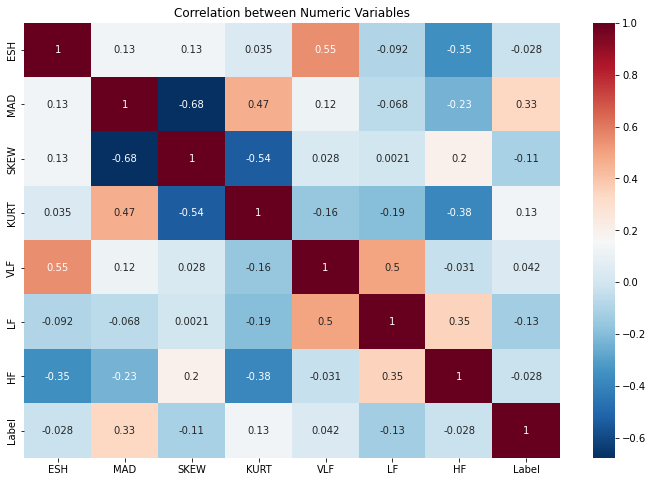

In [34]:
# Import library untuk plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Plot Korelasi antar fitur menggunakan heatmap seaborn
corr_butterworth = butterworth.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_butterworth, cmap="RdBu_r",annot=True)

plt.title('Correlation between Numeric Variables')
plt.show()

In [35]:
corr_features = correlation(butterworth_feat,0.5) #threshold = 0.5
len(set(corr_features))
print('Correlated features: ', len(set(corr_features)))
print('Correlated features are: ', corr_features)
print('Fitur',corr_features," akan dihapus")
print('Maka Fitur yang terpilih adalah MAD, ESH, LF dan HF')

Correlated features:  3
Correlated features are:  {'KURT', 'SKEW', 'VLF'}
Fitur {'KURT', 'SKEW', 'VLF'}  akan dihapus
Maka Fitur yang terpilih adalah MAD, ESH, LF dan HF


# **Feature Selection : Recursive Feature Elimination**

In [ ]:
# Import Library untuk perhitungan Metode RFE
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

## *Denoising Butterworth*

In [39]:
# Menentukan core model classifier untuk membantu perhitungan skor feature importance
rfe = RandomForestClassifier(random_state = 32)
# Mencari jumlah fitur yang optimal untuk digunakan
rfecv  = RFECV(estimator= rfe, step=1, cv=StratifiedKFold(2), scoring="accuracy")
fit = rfecv.fit(butterworth_feat, butterworth_label)
print("Optimal number of features : %d" % rfecv.n_features_)

# Menghitung Urutan fitur yang paling optimal
rfc = RandomForestClassifier()
rfe = RFE(estimator=rfc, n_features_to_select= 3, step=1)
rfe.fit(butterworth_feat, butterworth_label)

# Mengurutkan fitur berdasarkan ranking
for i in range(butterworth_feat.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

# Menampilkan fitur yang terpilih
selected_butterworth = butterworth_feat.iloc[:,rfe.support_]
print(selected_butterworth.head())
print('Fitur yang terpilih adalah ESH, Mad dan Skew')

Optimal number of features : 3
Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected False, Rank: 2.000
Column: 3, Selected False, Rank: 4.000
Column: 4, Selected False, Rank: 3.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected False, Rank: 5.000
         ESH       MAD        LF
0  12.667555  0.079907  0.000101
1  12.674413  0.076343  0.000003
2  12.668663  0.096521  0.000072
3  12.673751  0.084913  0.000228
4  12.683872  0.114613  0.000251
Fitur yang terpilih adalah ESH, Mad dan Skew
